In [1]:
import matplotlib.pyplot as plt
import os,glob,imp,copy
import pyslha
import numpy as np
import seaborn as sns
import tarfile
import pyslha, copy, pickle
from scipy.signal import savgol_filter
from scipy.interpolate import griddata
sns.set() #Set style
sns.set_style('ticks',{'font.family':'serif', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
sns.set_palette(sns.color_palette("Paired"))

In [2]:
def getContour(xpts,ypts,zpts,levels,ylog=False,xlog=False):
    """
    Uses pyplot tricontour method to obtain contour
    curves in a 2D plane.

    :return: A dictionary with a list of contours for each level
    """
    
    fig = plt.figure()
    x = copy.deepcopy(xpts)
    y = copy.deepcopy(ypts)
    z = copy.deepcopy(zpts)
    
    #Use log scale:
    if ylog:
        y = np.log10(y)
    if xlog:
        x = np.log10(x)
    
    CS = plt.tricontour(x,y,z,levels=levels)    
    levelPts = {}
    for il,level in enumerate(CS.levels):
        levelPts[level] = []
        c = CS.collections[il]        
        paths = c.get_paths()
        for path in paths:
            levelPts[level].append(path.vertices)
    plt.close(fig)
    
    #scale back:
    if ylog or xlog:
        for key,ptsList in levelPts.items():
            newList = []
            for pts in ptsList:
                xpts = pts[:,0]
                ypts = pts[:,1]
                if xlog:
                    xpts = 10**xpts
                if ylog:
                    ypts = 10**ypts
                newList.append(np.column_stack((xpts,ypts)))
            levelPts[key] = newList
        
    
    return levelPts

### Get official ATLAS UL map

In [3]:
ULmap = np.genfromtxt('./UpperLimitEW.csv',names=True,skip_header=10,delimiter=',')
print(ULmap.dtype.names)

('MCHARGINO1_GEV', 'TAUCHARGINO1_NS', 'The_95__CL_s_upper_limits_on_the_production_crosssection_fb')


### Get LO cross-sections

In [4]:
tarball = '/home/lessa/smodels-utils/slha/TDTM1M2F.tar.gz'
tar = tarfile.open(tarball, "r:gz")
tar.extractall('./TDTM1M2F/')
tar.close()

In [5]:
pts = []
for f in glob.glob('./TDTM1M2F/*slha'):
    data = pyslha.readSLHAFile(f)
    mC1 = data.blocks['MASS'][1000024]
    width = data.decays[1000024].totalwidth
    ctau = 6.582e-25/width
    ctau_ns = ctau/1e-9
    lctau_ns = np.log10(ctau_ns)
    xsecC1C1 = [x for x in data.xsections[(2212,2212,-1000024,1000024)].xsecs if x.sqrts == 13000.][0].value
    xsecC1pN1 = [x for x in data.xsections[(2212,2212,1000022,1000024)].xsecs if x.sqrts == 13000.][0].value
    xsecC1mN1 = [x for x in data.xsections[(2212,2212,-1000024,1000022)].xsecs if x.sqrts == 13000.][0].value
    xsectot = xsecC1C1+xsecC1pN1+xsecC1mN1
    pts.append([mC1,ctau_ns,lctau_ns,xsectot])
pts = np.array(pts)

### Interpolate ATLAS UL map:

In [51]:
uls = griddata(list(zip(ULmap['MCHARGINO1_GEV'],ULmap['TAUCHARGINO1_NS'])),
         ULmap['The_95__CL_s_upper_limits_on_the_production_crosssection_fb'],
         pts[:,[0,1]])

### Plot results

In [52]:
rvalues = np.nan_to_num(pts[:,3]/uls)

In [53]:
excCurve = getContour(pts[:,0],pts[:,1],rvalues,levels=[0.8,1.0],ylog=True)

In [54]:
#Official curve
excATLAS = np.genfromtxt('../orig/HEPData-ins1641262-v4-Exclusion_contour_EW_2_obs_conv.txt',
                       names=True)

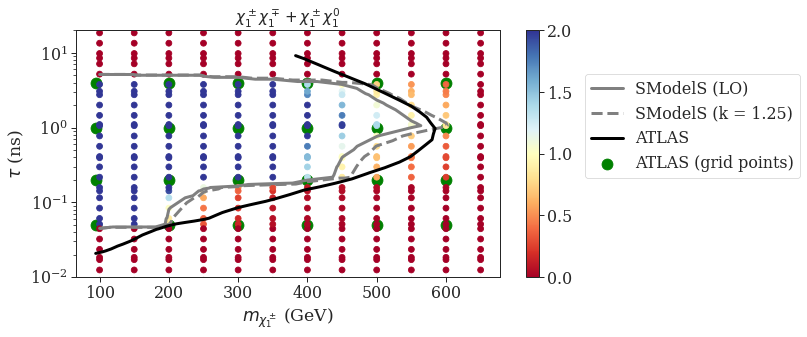

In [55]:
fig = plt.figure(figsize=(14,5))
plt.scatter(ULmap['MCHARGINO1_GEV'],ULmap['TAUCHARGINO1_NS'],marker='o',c='green',s=120,
            label='ATLAS (grid points)')
plt.scatter(pts[:,0],pts[:,1],c=rvalues,s=35,cmap=plt.cm.get_cmap('RdYlBu'), vmin=0., vmax=2.)
plt.plot(excCurve[1.0][0][:,0],excCurve[1.0][0][:,1],
         label='SModelS (LO)',
         linewidth=3,linestyle='-',color='gray')

plt.plot(excCurve[0.8][0][:,0],excCurve[0.8][0][:,1],
         label='SModelS (k = 1.25)',
         linewidth=3,linestyle='--',color='gray')



plt.plot(excATLAS['mC1_GeV'],1e9*6.582e-25/excATLAS['width_GeV'],label='ATLAS',linewidth=3,linestyle='-',color='black')
plt.ylabel(r'$\tau$ (ns)')
plt.xlabel(r'$m_{\chi_1^\pm}$ (GeV)')
plt.yscale('log')
plt.title(r'$\chi_1^\pm \chi_1^\mp + \chi_1^\pm \chi_1^0$',fontsize=15)
plt.ylim(0.01,20)
plt.legend(loc=(1.2,0.4))
plt.tight_layout()
plt.colorbar()
plt.show()